##### Copyright 2025 Google LLC.

In [20]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Use Gemini thinking

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking_REST.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

[Gemini 2.5 Flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash-preview-04-17) and [Gemini 2.5 Pro](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-preview-03-25) are models that are
trained to do a [thinking process](https://ai.google.dev/gemini-api/docs/thinking-mode) (or reasoning) before getting to a final answer. As a result,
those models are capable of stronger reasoning capabilities in its responses than previous models.

This notebook demonstrates how to control and observe this thinking behavior by making direct REST API calls to the `generateContent` endpoint.

You'll see examples involving geometry, travia, math problems and brain teaser. The model's internal reasoning isn't automatically displayed as separate output in the REST response itself (unless the prompt or thinking process leads the model to include it in the final content), but you can observe its impact on the final answer and check the `usageMetadata` in the response to see if thinking tokens were used.


### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GEMINI_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [5]:
from google.colab import userdata

GEMINI_API_KEY=userdata.get('GEMINI_API_KEY')

### Understanding the "thinking" models and `thinking_budget` via REST

[Gemini 2.5 models](https://ai.google.dev/gemini-api/docs/thinking-mode) are optimized for complex tasks that need multiple rounds of strategyzing and iteratively solving.

When making REST API calls, you control the thinking behavior by including a `thinkingConfig` object within the `generationConfig` in your JSON request payload.

[Gemini 2.5 Flash](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash-preview-04-17) in particular, brings the flexibility of using `thinking_budget` - a parameter
that offers fine-grained control over the maximum number of tokens a model can generate while thinking. Alternatively, you can designate a precise token allowance for the
"thinking" stage through the adjusment of the `thinking_budget` parameter. This allowance can vary between 0 and 24576 tokens for 2.5 Flash.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

**NOTE:** On this notebook all examples are using Gemini 2.5 Flash and the new `thinking_budget` parameter.
The `thinking_budget` parameter is not available for Gemini 2.5 Pro for now - If you want to use Gemini 2.5 Pro, you can remove the `thinking_budget` parameter from the code.

In [6]:
import json
import requests

MODEL_ID="gemini-2.5-flash-preview-04-17" # @param ["gemini-2.5-flash-preview-04-17", "gemini-2.5-pro-preview-03-25"] {"allow-input":true, isTemplate: true}
url = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_ID}:generateContent?key={GEMINI_API_KEY}"

# 1/ Examples

Here are some quite complex examples of what Gemini 2.5 thinking model can solve.

In each of them you can select different models to see how this new model compares to its predecesors.

In some cases, you'll still get the good answer from the other models, in that case, re-run it a couple of times and you'll see that Gemini 2.5 thinking is more consistent thanks to its thinking step.

## Example #1: Brain Teaser with Thinking

You can start by asking the model to explain a concept and see how it does reasoning before answering.

Starting with the adaptive `thinking_budget` - which is the default when you don't specify a budget - the model will dynamically adjust the budget based on the complexity of the request.

In [7]:
from IPython.display import Markdown

prompt = """
    You are playing the 20 question game. You know that what you are looking for
    is a aquatic mammal that doesn't live in the sea, and that's smaller than a
    cat. What could that be and how could you make sure?
"""
# The animal I'm thinking of is a platipus

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ]
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

Markdown(response['candidates'][0]['content']['parts'][0]['text'])

Okay, let's break down the constraints you've been given in this round of 20 Questions:

1.  **Aquatic Mammal:** It lives in water and is a mammal (warm-blooded, has fur/hair, mothers produce milk).
2.  **Doesn't live in the sea:** This means it lives in **freshwater** (lakes, rivers, ponds, swamps).
3.  **Smaller than a cat:** This is a size constraint.

Let's think about freshwater aquatic mammals and see which ones are smaller than a typical house cat:

*   **Beavers:** Too big.
*   **Otters:** Most species are larger than a cat, especially the Giant Otter. Some smaller otters might be close in weight to a large cat, but are usually longer. Generally too big.
*   **Muskrats:** These are rodents closely related to voles, but adapted for semi-aquatic life. They typically weigh 1.5 to 4 pounds and are 16-24 inches long (including the tail). A typical house cat weighs 8-10 pounds (though they can be smaller or larger) and is about 18 inches long plus tail. A muskrat is definitely often smaller than a cat, especially in weight.
*   **Platypus:** Found in Australia. It's a monotreme (lays eggs) but is often thought of as a mammal. They are typically 12-15 inches long and weigh 1.5 to 5.3 pounds. Also fits the "smaller than a cat" criteria.
*   **River Dolphins:** Much, much larger than a cat.
*   **Hippos:** Much, much larger than a cat.
*   **Baikal Seal:** A seal living in Russia's Lake Baikal. Much larger than a cat.

Based on the criteria, the most likely and common answer is a **Muskrat**. A **Platypus** is also a possibility, though less widespread geographically.

**What could that be?**

A **Muskrat**.

**How could you make sure?**

Since you already know the three main constraints (aquatic mammal, freshwater, smaller than a cat), the "making sure" part using 20 Questions would involve asking questions to confirm it's specifically a muskrat (or perhaps differentiate it from the platypus, the other likely candidate). Here are some questions you could ask, staying within the 20 questions limit:

1.  **Does it build a lodge or den in the water?** (Muskrats build lodges or bank dens; Platypuses primarily have burrows)
2.  **Does it have a flat, vertically compressed tail?** (Muskrats do; Platypuses have a beaver-like flat, horizontal tail)
3.  **Does it have a bill like a duck?** (Platypus does; Muskrat does not) - *This is a very strong differentiator.*
4.  **Is it found in North America?** (Muskrats are; Platypuses are not) - *Another strong differentiator.*
5.  **Does it primarily eat plants?** (Muskrats eat a lot of vegetation, but also small animals; Platypuses eat invertebrates like worms and insects) - *Less definitive, but can help.*
6.  **Does it lay eggs?** (Platypus does; Muskrat does not - it gives birth to live young) - *Definitive proof it's a placental mammal like a muskrat, not a monotreme.*

By asking questions like these that focus on specific physical characteristics, geographic location, or reproductive methods, you can confidently confirm that the creature fitting the initial criteria is indeed a Muskrat (or rule out a Platypus if that were the case).

Inspecting the Response Metadata: After making the REST call, the response JSON contains usageMetadata. This object provides information about the token counts for the request. Look for the `thoughtsTokenCount` field within usageMetadata to see how many tokens were consumed by the thinking process for this request. You'll also see `promptTokenCount`, `candidatesTokenCount` (for the final output), and `totalTokenCount`. As you can see here, the model used a significant number of tokens in the thinking steps.

In [8]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"])
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 58
Thoughts tokens: 1477
Output tokens: 820
Total tokens: 2355


### Disabling the thinking steps

You can explicitly disable the thinking steps by including the `thinkingConfig` object in the `generationConfig` and setting the `thinkingBudget` parameter to `0` in the JSON payload. This tells the model not to perform any internal reasoning steps before generating the final output. You'll likely see that in this case, the model doesn't think of the platypus as a possible answer.

In [9]:
prompt = """
    You are playing the 20 question game. You know that what you are looking for
    is a aquatic mammal that doesn't live in the sea, and that's smaller than a
    cat. What could that be and how could you make sure?
"""

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": 0
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

Markdown(response['candidates'][0]['content']['parts'][0]['text'])

Okay, let's break this down. We're looking for an animal with these characteristics:

* **Aquatic Mammal:** It's a mammal that lives in water.
* **Doesn't live in the sea:** This rules out whales, dolphins, seals, sea lions, manatees, and dugongs.
* **Smaller than a cat:** This is a significant size constraint.

Given these clues, here's a strong candidate and how you could verify:

**Candidate:**

* **River Otter (specifically, a young or smaller species/individual):** While adult river otters are typically larger than a house cat, some species, particularly young ones, can be smaller. They are definitely aquatic mammals that live in freshwater environments (rivers, lakes, swamps).

**How to make sure (in a 20 questions game context):**

Since we're playing 20 questions, you can't just say "Is it a young river otter?". You need to ask questions that narrow down the possibilities based on the clues you already have. Here's how you could approach it:

1. **Focus on the "Doesn't live in the sea" and "Aquatic Mammal":**
   * **Question:** Does it live in freshwater? (This directly confirms the "doesn't live in the sea" and reinforces the aquatic nature).
   * **Expected Answer:** Yes.

2. **Refine the size constraint:**
   * **Question:** Is it typically found in North America? (This is a common range for some smaller otter species).
   * **Expected Answer:** Could be yes or no, but a yes would lean towards some otter species.
   * **Question:** Does its average adult weight exceed 10 pounds? (A typical adult cat is around 8-10 pounds. Asking about average adult weight helps distinguish from a fully grown, larger animal).
   * **Expected Answer:** Likely Yes for most adult otters. This is where the "smaller than a cat" becomes tricky. You might need to adjust your understanding based on the age of the animal being considered.

3. **Zero in on the "Smaller than a cat" with more specific questions, knowing your suspicion:**
   * **Question:** Is the animal you're thinking of a baby? (This directly addresses the size discrepancy if you suspect an otter).
   * **Expected Answer:** Possibly Yes.
   * **Question:** Is it a type of otter? (This is a strong guess based on the other clues).
   * **Expected Answer:** Hopefully Yes if you're on the right track!
   * **Question:** Is it an animal known for being playful? (Otters are known for this, it's a characteristic that might help confirm).
   * **Expected Answer:** Likely Yes.

**If the answers consistently align with an otter, especially a young one, then you're very likely thinking of a baby or smaller species of river otter.**

**Other Less Likely Possibilities (but worth considering in a 20 Questions context):**

* **Water Shrew:** While they are mammals and somewhat aquatic, they are *much* smaller than a cat and primarily insectivores, not typically thought of as "aquatic mammals" in the same way as otters. You could ask questions about its diet or typical habitat (very small streams, damp areas) to rule this out.
* **Muskrat Kit:** Very young muskrats could be smaller than a cat, and they are aquatic mammals that live in freshwater. However, adult muskrats are usually larger. You could ask questions about its tail (flat and scaly) or diet (mostly plants) to distinguish it from an otter.

**In summary, based on the criteria, a young or smaller river otter is the most plausible answer. Your 20 Questions strategy would focus on confirming its freshwater habitat, refining the size based on age, and eventually asking about its species or characteristics associated with otters.**

Now you can see that the response is faster as the model didn't perform any thinking step. Also you can see that no tokens were used for the thinking step:

In [10]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"] if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 58
Thoughts tokens: None
Output tokens: 841
Total tokens: 899


## Example #2: Physics problem

Now, try with a simple physics comprehension example. First you can disable the `thinking_budget` to see how the model performs:

In [11]:
prompt = """
    A cantilever beam of length L=3m has a rectangular cross-section (width b=0.1m, height h=0.2m) and is made of steel (E=200 GPa).
    It is subjected to a uniformly distributed load w=5 kN/m along its entire length and a point load P=10 kN at its free end.
    Calculate the maximum bending stress (σ_max).
"""

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": 0
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

Markdown(response['candidates'][0]['content']['parts'][0]['text'])

Here's the calculation of the maximum bending stress for the cantilever beam:

**1. Calculate the maximum bending moment (M_max):**

For a cantilever beam with a uniformly distributed load and a point load at the free end, the maximum bending moment occurs at the fixed support.

* **Bending moment due to the uniformly distributed load (M_w):**
   M_w = (w * L^2) / 2
   M_w = (5 kN/m * (3 m)^2) / 2
   M_w = (5 kN/m * 9 m^2) / 2
   M_w = 22.5 kN.m

* **Bending moment due to the point load (M_P):**
   M_P = P * L
   M_P = 10 kN * 3 m
   M_P = 30 kN.m

* **Total maximum bending moment (M_max):**
   M_max = M_w + M_P
   M_max = 22.5 kN.m + 30 kN.m
   M_max = 52.5 kN.m

**2. Convert the bending moment to Newton-meters (N.m):**

M_max = 52.5 kN.m * 1000 N/kN
M_max = 52500 N.m

**3. Calculate the moment of inertia (I) of the rectangular cross-section:**

The moment of inertia for a rectangular cross-section about the neutral axis is:
I = (b * h^3) / 12
I = (0.1 m * (0.2 m)^3) / 12
I = (0.1 m * 0.008 m^3) / 12
I = 0.0008 m^4 / 12
I = 6.6667 x 10^-5 m^4

**4. Determine the distance to the extreme fiber (y):**

For a rectangular cross-section, the extreme fiber is located at the top or bottom surface, which is half of the height (h/2).
y = h / 2
y = 0.2 m / 2
y = 0.1 m

**5. Calculate the maximum bending stress (σ_max):**

The bending stress is given by the formula:
σ = (M * y) / I

The maximum bending stress occurs where the bending moment is maximum and the distance to the extreme fiber is maximum.
σ_max = (M_max * y) / I
σ_max = (52500 N.m * 0.1 m) / (6.6667 x 10^-5 m^4)
σ_max = 5250 N.m^2 / (6.6667 x 10^-5 m^4)
σ_max = 78749999.99 Pa

**6. Convert the stress to Megapascals (MPa):**

σ_max = 78749999.99 Pa / 10^6 Pa/MPa
σ_max ≈ 78.75 MPa

**Therefore, the maximum bending stress (σ_max) in the cantilever beam is approximately 78.75 MPa.**

Metadata (Thinking Disabled): As expected, the `usageMetadata` for this request should show a `thoughtsTokenCount` of `0` or absence, as thinking was explicitly disabled in the request payload.

In [12]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"] if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 95
Thoughts tokens: None
Output tokens: 761
Total tokens: 856


Then, set a fixed maximum budget `(e.g., thinking_budget=4096)` for the thinking step by including the `thinkingConfig` object with `thinkingBudget` set in the JSON payload. See how the model's output changes.

In [13]:
prompt = """
    A cantilever beam of length L=3m has a rectangular cross-section (width b=0.1m, height h=0.2m) and is made of steel (E=200 GPa).
    It is subjected to a uniformly distributed load w=5 kN/m along its entire length and a point load P=10 kN at its free end.
    Calculate the maximum bending stress (σ_max).
"""

thinking_budget = 4096 # @param {type:"slider", min:0, max:24576, step:1}

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt}
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": thinking_budget
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()

Markdown(response['candidates'][0]['content']['parts'][0]['text'])

Okay, let's calculate the maximum bending stress step-by-step.

1.  **Identify the location of maximum bending moment:** For a cantilever beam under downward loads, the maximum bending moment occurs at the fixed support.

2.  **Calculate the bending moment at the fixed support due to the point load (P):**
    M_P = P * L
    M_P = 10 kN * 3 m = 30 kN.m
    Convert to N.m: M_P = 30 * 10³ N.m

3.  **Calculate the bending moment at the fixed support due to the uniformly distributed load (w):**
    M_w = w * L * (L/2) = w * L²/2
    M_w = (5 kN/m) * (3 m)² / 2 = 5 * 9 / 2 = 45 / 2 = 22.5 kN.m
    Convert to N.m: M_w = 22.5 * 10³ N.m

4.  **Calculate the total maximum bending moment (M_max) at the fixed support:**
    Since both loads cause bending in the same direction at the support, the moments add up.
    M_max = M_P + M_w
    M_max = 30 * 10³ N.m + 22.5 * 10³ N.m = 52.5 * 10³ N.m

5.  **Calculate the area moment of inertia (I) of the rectangular cross-section:**
    The formula for a rectangle about its neutral axis (centroid) is I = (b * h³) / 12.
    b = 0.1 m, h = 0.2 m
    I = (0.1 m * (0.2 m)³) / 12
    I = (0.1 * 0.008) / 12 m⁴
    I = 0.0008 / 12 m⁴
    I = 8 * 10⁻⁴ / 12 m⁴ = 2 * 10⁻⁴ / 3 m⁴ ≈ 6.667 * 10⁻⁵ m⁴

6.  **Identify the maximum distance from the neutral axis (y_max):**
    For a rectangular section, the neutral axis is at mid-height. The maximum stress occurs at the top or bottom surface, which is h/2 from the neutral axis.
    y_max = h / 2 = 0.2 m / 2 = 0.1 m

7.  **Calculate the maximum bending stress (σ_max):**
    The bending stress formula is σ = (M * y) / I. The maximum stress occurs at M_max and y_max.
    σ_max = (M_max * y_max) / I
    σ_max = (52.5 * 10³ N.m * 0.1 m) / (2 * 10⁻⁴ / 3 m⁴)
    σ_max = (5.25 * 10³ N.m²) / (2 * 10⁻⁴ / 3 m⁴)
    σ_max = (5.25 * 10³) * (3 / (2 * 10⁻⁴)) N/m²
    σ_max = (5.25 * 10³) * (1.5 * 10⁴) N/m²
    σ_max = 7.875 * 10⁷ N/m²

8.  **Convert the stress to MPa:**
    1 N/m² = 1 Pa
    1 MPa = 10⁶ Pa = 10⁶ N/m²
    σ_max = 7.875 * 10⁷ N/m² = 78.75 * 10⁶ N/m² = 78.75 MPa

The maximum bending stress is 78.75 MPa. (Note: The Young's Modulus E is not needed for calculating the stress itself, only for deflection or strain).

**Final Answer:** The maximum bending stress is **78.75 MPa**.

Metadata (Thinking Enabled): Now, examine the `usageMetadata` for the call where `thinkingBudget` was set to a positive value. You should see a non-zero `thoughtsTokenCount`, indicating the number of tokens used for the thinking process (which will be less than or equal to the `thinkingBudget` you set).

In [14]:
print("Prompt tokens:",response["usageMetadata"]["promptTokenCount"])
print("Thoughts tokens:",response["usageMetadata"]["thoughtsTokenCount"], '/', thinking_budget if "thoughtsTokenCount" in response["usageMetadata"] else "None")
print("Output tokens:", response["usageMetadata"]["candidatesTokenCount"])
print("Total tokens:", response["usageMetadata"]["totalTokenCount"])

Prompt tokens: 95
Thoughts tokens: 1674 / 4096
Output tokens: 955
Total tokens: 2724


Keep in mind that the largest the thinking budget is, the longest the model will spend time thinking, with means a longer computation time and a more expensive request.

## Example #3: Geometry problem (with image)

This geometry problem requires complex reasoning and is also using Gemini multimodal abilities to read the image.
In this case, you are fixing a value to the `thinking_budget` so the model will use up to 8196 tokens for the thinking step.

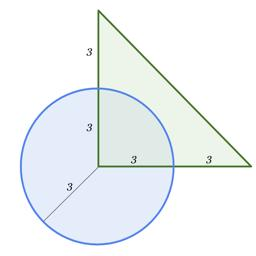

In [15]:
import base64
from PIL import Image

!wget https://storage.googleapis.com/generativeai-downloads/images/geometry.png -O geometry.png -q

display(Image.open("geometry.png").resize((256,256)))

with open("geometry.png", "rb") as image_file:
     encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

In [16]:
prompt = "What's the area of the overlapping region?"

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": 8196
          }
    }
}


response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()


Markdown(response['candidates'][0]['content']['parts'][0]['text'])

The triangle is a right-angled triangle with legs of length 3. From the image, it appears that the right angle is at the origin, and the legs lie along the positive x and y axes. The vertices of the triangle are thus (0,0), (3,0), and (0,3).

The circle is centered at the origin (0,0), and its radius is 3, as indicated by the segments of length 3 from the center to the circumference. The equation of the circle is $x^2 + y^2 = 3^2 = 9$. The region inside the circle is given by $x^2 + y^2 \le 9$.

The triangle is in the first quadrant and is defined by the inequalities $x \ge 0$, $y \ge 0$, and the line connecting (3,0) and (0,3), which has the equation $x+y=3$. Since the triangle contains the origin, the inequality is $x+y \le 3$. So, the triangle is the set of points (x,y) such that $x \ge 0$, $y \ge 0$, and $x+y \le 3$.

The overlapping region is the intersection of the triangle and the circle, i.e., the set of points (x,y) such that $x \ge 0$, $y \ge 0$, $x+y \le 3$, and $x^2 + y^2 \le 9$.

We need to determine if the entire triangle is contained within the circle.
Let (x,y) be a point in the triangle. Then $x \ge 0$, $y \ge 0$, and $x+y \le 3$.
We need to check if $x^2 + y^2 \le 9$.
Since $x \ge 0$ and $y \ge 0$, $x^2 \le x^2+y^2$ and $y^2 \le x^2+y^2$.
Consider the vertices of the triangle:
(0,0): $0^2+0^2 = 0 \le 9$.
(3,0): $3^2+0^2 = 9 \le 9$.
(0,3): $0^2+3^2 = 9 \le 9$.
Since the vertices of the triangle are inside or on the circle, and the circle (a disk) is a convex set, and the triangle is a convex set with vertices in the circle, the entire triangle is contained within the circle.

Alternatively, consider any point (x,y) in the triangle. Then $x \ge 0, y \ge 0, x+y \le 3$. We want to maximize $f(x,y) = x^2+y^2$ subject to these constraints. Since the constraints define a convex set and the function is convex, the maximum occurs at the vertices. The maximum value is 9, occurring at (3,0) and (0,3). Since the maximum value of $x^2+y^2$ within the triangle is 9, all points (x,y) in the triangle satisfy $x^2+y^2 \le 9$. Therefore, the entire triangle is contained in the circle.

The overlapping region is the triangle itself.
The area of a right-angled triangle with legs of length 3 is given by $\frac{1}{2} \times \text{base} \times \text{height} = \frac{1}{2} \times 3 \times 3 = \frac{9}{2}$.

The final answer is $\boxed{9/2}$.

## Example #4: Brain teaser with a twist

Here's another brain teaser based on an image, this time it looks like a mathematical problem, but it cannot actually be solved mathematically. If you check the toughts of the model you'll see that it will realize it and come up with an out-of-the-box solution.

In this case, you are fixing a value to the `thinking_budget` so the model will use up to 24576 tokens for the thinking step.

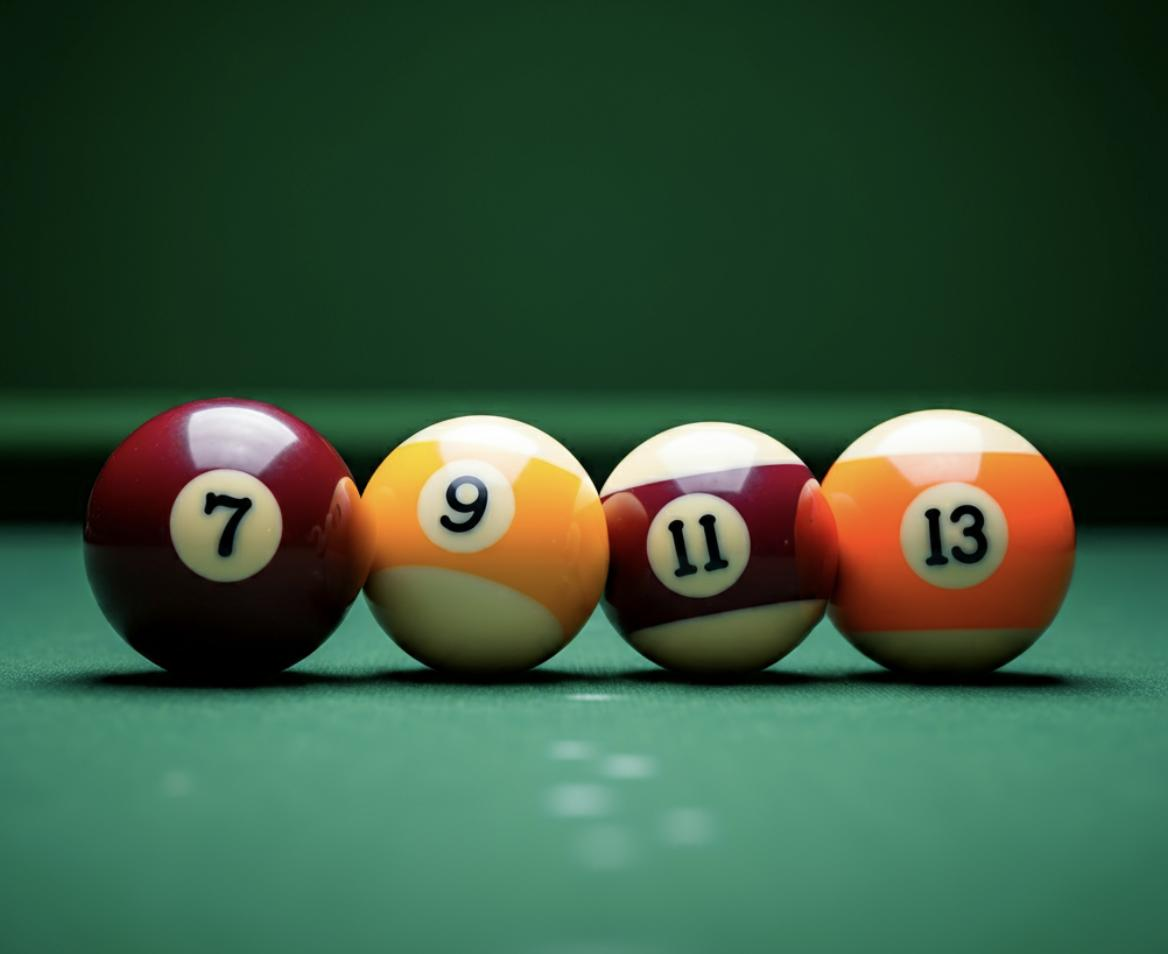

In [17]:
!wget https://storage.googleapis.com/generativeai-downloads/images/pool.png -O pool.png -q

display(Image.open("pool.png"))

with open("pool.png", "rb") as image_file:
     encoded_string = base64.b64encode(image_file.read()).decode("utf-8")

In [18]:
prompt = "How do I use and manipulate three of the pool balls to sum up to 30?"

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": 24576
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()


Markdown(response['candidates'][0]['content']['parts'][0]['text'])

This is a classic riddle! The key is the word "manipulate" and how the number 9 on a pool ball can be manipulated.

1.  Look at the numbers on the balls: 7, 9, 11, and 13.
2.  Notice that if you *rotate* the number 9 ball upside down, it becomes a 6.
3.  Now, you have the numbers 7, (6), 11, and 13 available (treating the 9 as a 6).
4.  Pick three of these numbers that add up to 30.
5.  The combination is 11 + 13 + 6.

So, you use the **11 ball**, the **13 ball**, and the **9 ball (turned upside down to represent a 6)**.

11 + 13 + 6 = 30.

## Example #5: Math puzzle

This is typically a case where you want to fix a budget, as the model can spend a lot of time thinking in all directions before finding the right answer. It should not be too low either as non-thinking models have trouble with such questions.

Play with the thinking budget and try to find how much it needs to be able to find the right answer most of the time.

Note that Pro is usually better than Flash for those kind of riddles, but does not have the thinking budget yet.

In [19]:
prompt = """
   How can you obtain 565 with 10 8 3 7 1 and 5 and the common operations?
   You can only use a number once.
"""

thinking_budget = 24576 # @param {type:"slider", min:0, max:24576, step:1}

data = {
    "contents": [
        {
            "parts": [
                {"text": prompt},
                {
                    "inlineData": {
                        "mimeType": "image/png",
                        "data": encoded_string
                    }
                }
            ]
        }
    ],
     "generationConfig": {
          "thinkingConfig": {
              "thinkingBudget": 24576
          }
    }
}

response = requests.post(
   url,
   headers={'Content-Type': 'application/json'},
   data=json.dumps(data)
).json()


Markdown(response['candidates'][0]['content']['parts'][0]['text'])

You can obtain 565 using the numbers 10, 8, 3, 7, 1, and 5 with common operations as follows:

First, combine some of the numbers to get an intermediate result:
10 + 7 = 17
17 - 3 = 14

Next, multiply this result by another number from the set:
14 * 8 = 112

Then, add another number from the set:
112 + 1 = 113

Finally, multiply this result by the last remaining number:
113 * 5 = 565

Putting it all together in a single expression:
(((10 + 7 - 3) * 8) + 1) * 5 = 565

Let's verify the usage of numbers and operations:
Numbers used: 10, 7, 3, 8, 1, 5. All the given numbers are used exactly once.
Operations used: addition (+), subtraction (-), multiplication (*), addition (+), multiplication (*). These are common operations.

Calculation steps:
10 + 7 = 17
17 - 3 = 14
14 * 8 = 112
112 + 1 = 113
113 * 5 = 565

The expression is valid.

The final answer is $\boxed{(((10 + 7 - 3) * 8) + 1) * 5 = 565}$.

# Next Steps

Try Gemini 2.5 Pro Experimental in
[Google AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.5-pro-exp-03-25), and learn more about [Prompting for thinking models](https://ai.google.dev/gemini-api/docs/prompting-with-thinking).

For more examples of the Gemini capabilities, check the other [Cookbook examples](https://github.com/google-gemini/cookbook). You'll learn how to use the [Live API](./Get_started.ipynb), juggle with [multiple tools](../examples/LiveAPI_plotting_and_mapping.ipynb) or use Gemini [spatial understanding](./Spatial_understanding.ipynb) abilities.